# Ant Colony Optimization (ACO)

## Introduction

Ant Colony Optimization (ACO) is a probabilistic technique for solving computational problems that can be reduced to finding good paths through graphs. This metaheuristic algorithm was introduced by Marco Dorigo in 1992, inspired by the foraging behavior of real ants.

## Biological Inspiration

In nature, ants initially wander randomly. Upon finding food, they return to their colony while laying down pheromone trails. Other ants follow these trails, and if they find food, they reinforce the trails with more pheromones. Over time, shorter paths accumulate more pheromones (since ants can traverse them more quickly), leading to the emergence of optimal routes.

## Mathematical Formulation

### Transition Probability

The probability that ant $k$ at node $i$ will move to node $j$ is given by:

$$p_{ij}^k = \frac{[\tau_{ij}]^\alpha \cdot [\eta_{ij}]^\beta}{\sum_{l \in \mathcal{N}_i^k} [\tau_{il}]^\alpha \cdot [\eta_{il}]^\beta}$$

where:
- $\tau_{ij}$ is the pheromone intensity on edge $(i, j)$
- $\eta_{ij} = \frac{1}{d_{ij}}$ is the heuristic desirability (inverse of distance)
- $\alpha$ is the pheromone influence parameter
- $\beta$ is the heuristic influence parameter
- $\mathcal{N}_i^k$ is the set of feasible nodes for ant $k$ at node $i$

### Pheromone Update Rule

After all ants complete their tours, the pheromone levels are updated according to:

$$\tau_{ij} \leftarrow (1 - \rho) \cdot \tau_{ij} + \sum_{k=1}^{m} \Delta\tau_{ij}^k$$

where:
- $\rho \in (0, 1]$ is the pheromone evaporation rate
- $m$ is the number of ants
- $\Delta\tau_{ij}^k$ is the pheromone deposited by ant $k$

### Pheromone Deposit

The amount of pheromone deposited by ant $k$ on edge $(i, j)$ is:

$$\Delta\tau_{ij}^k = \begin{cases} \frac{Q}{L_k} & \text{if ant } k \text{ uses edge } (i, j) \\ 0 & \text{otherwise} \end{cases}$$

where:
- $Q$ is a constant
- $L_k$ is the total length of the tour constructed by ant $k$

## Application: Traveling Salesman Problem (TSP)

We will demonstrate ACO on the classic Traveling Salesman Problem, where the goal is to find the shortest possible route that visits each city exactly once and returns to the origin city.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
class AntColonyOptimizer:
    """
    Ant Colony Optimization for solving the Traveling Salesman Problem.
    """
    
    def __init__(self, distances, n_ants, n_iterations, alpha=1.0, beta=2.0, 
                 rho=0.5, Q=100):
        """
        Initialize the ACO algorithm.
        
        Parameters:
        -----------
        distances : ndarray
            Distance matrix between cities
        n_ants : int
            Number of ants in the colony
        n_iterations : int
            Number of iterations to run
        alpha : float
            Pheromone influence parameter
        beta : float
            Heuristic influence parameter
        rho : float
            Pheromone evaporation rate
        Q : float
            Pheromone deposit constant
        """
        self.distances = distances
        self.n_cities = len(distances)
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.Q = Q
        
        # Initialize pheromone matrix with small positive values
        self.pheromones = np.ones((self.n_cities, self.n_cities)) * 0.1
        
        # Compute heuristic matrix (inverse of distance)
        # Add small epsilon to avoid division by zero
        self.heuristic = 1.0 / (distances + 1e-10)
        np.fill_diagonal(self.heuristic, 0)
        
        # Storage for results
        self.best_tour = None
        self.best_distance = np.inf
        self.history = []
        
    def _select_next_city(self, current_city, visited):
        """
        Select the next city based on transition probabilities.
        """
        unvisited = [c for c in range(self.n_cities) if c not in visited]
        
        if not unvisited:
            return None
        
        # Calculate transition probabilities
        pheromone_vals = self.pheromones[current_city, unvisited]
        heuristic_vals = self.heuristic[current_city, unvisited]
        
        probabilities = (pheromone_vals ** self.alpha) * (heuristic_vals ** self.beta)
        probabilities = probabilities / probabilities.sum()
        
        # Select next city using roulette wheel selection
        next_city = np.random.choice(unvisited, p=probabilities)
        return next_city
    
    def _construct_tour(self, start_city):
        """
        Construct a complete tour starting from a given city.
        """
        tour = [start_city]
        visited = {start_city}
        
        while len(tour) < self.n_cities:
            current_city = tour[-1]
            next_city = self._select_next_city(current_city, visited)
            tour.append(next_city)
            visited.add(next_city)
        
        return tour
    
    def _calculate_tour_distance(self, tour):
        """
        Calculate the total distance of a tour.
        """
        distance = 0
        for i in range(len(tour)):
            distance += self.distances[tour[i], tour[(i + 1) % len(tour)]]
        return distance
    
    def _update_pheromones(self, tours, distances):
        """
        Update pheromone levels based on ant tours.
        """
        # Evaporation
        self.pheromones *= (1 - self.rho)
        
        # Deposit pheromones
        for tour, dist in zip(tours, distances):
            deposit = self.Q / dist
            for i in range(len(tour)):
                city_a = tour[i]
                city_b = tour[(i + 1) % len(tour)]
                self.pheromones[city_a, city_b] += deposit
                self.pheromones[city_b, city_a] += deposit
    
    def optimize(self):
        """
        Run the ACO optimization algorithm.
        
        Returns:
        --------
        best_tour : list
            The best tour found
        best_distance : float
            The distance of the best tour
        """
        for iteration in range(self.n_iterations):
            tours = []
            distances = []
            
            # Each ant constructs a tour
            for ant in range(self.n_ants):
                start_city = np.random.randint(self.n_cities)
                tour = self._construct_tour(start_city)
                distance = self._calculate_tour_distance(tour)
                
                tours.append(tour)
                distances.append(distance)
                
                # Update best solution
                if distance < self.best_distance:
                    self.best_distance = distance
                    self.best_tour = tour.copy()
            
            # Update pheromones
            self._update_pheromones(tours, distances)
            
            # Record history
            self.history.append({
                'iteration': iteration,
                'best_distance': self.best_distance,
                'mean_distance': np.mean(distances),
                'min_distance': np.min(distances)
            })
            
            if (iteration + 1) % 20 == 0:
                print(f"Iteration {iteration + 1}: Best distance = {self.best_distance:.2f}")
        
        return self.best_tour, self.best_distance

## Generate Test Data

We will create a set of randomly distributed cities in a 2D plane and compute the Euclidean distance matrix.

In [3]:
# Generate random city coordinates
n_cities = 25
cities = np.random.rand(n_cities, 2) * 100

# Compute distance matrix
def compute_distance_matrix(cities):
    """Compute Euclidean distance matrix between all cities."""
    n = len(cities)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.sqrt(np.sum((cities[i] - cities[j]) ** 2))
            distances[i, j] = dist
            distances[j, i] = dist
    return distances

distances = compute_distance_matrix(cities)
print(f"Number of cities: {n_cities}")
print(f"Distance matrix shape: {distances.shape}")

Number of cities: 25
Distance matrix shape: (25, 25)


## Run ACO Algorithm

In [4]:
# Initialize and run ACO
aco = AntColonyOptimizer(
    distances=distances,
    n_ants=20,
    n_iterations=100,
    alpha=1.0,    # Pheromone influence
    beta=2.0,     # Heuristic influence
    rho=0.1,      # Evaporation rate
    Q=100         # Pheromone deposit constant
)

best_tour, best_distance = aco.optimize()
print(f"\nOptimization complete!")
print(f"Best tour distance: {best_distance:.2f}")

Iteration 20: Best distance = 448.79


Iteration 40: Best distance = 434.57


Iteration 60: Best distance = 434.57


Iteration 80: Best distance = 411.17


Iteration 100: Best distance = 411.17

Optimization complete!
Best tour distance: 411.17


## Visualization

Let's visualize the results: the convergence history, the pheromone intensity matrix, and the optimal tour found by the algorithm.

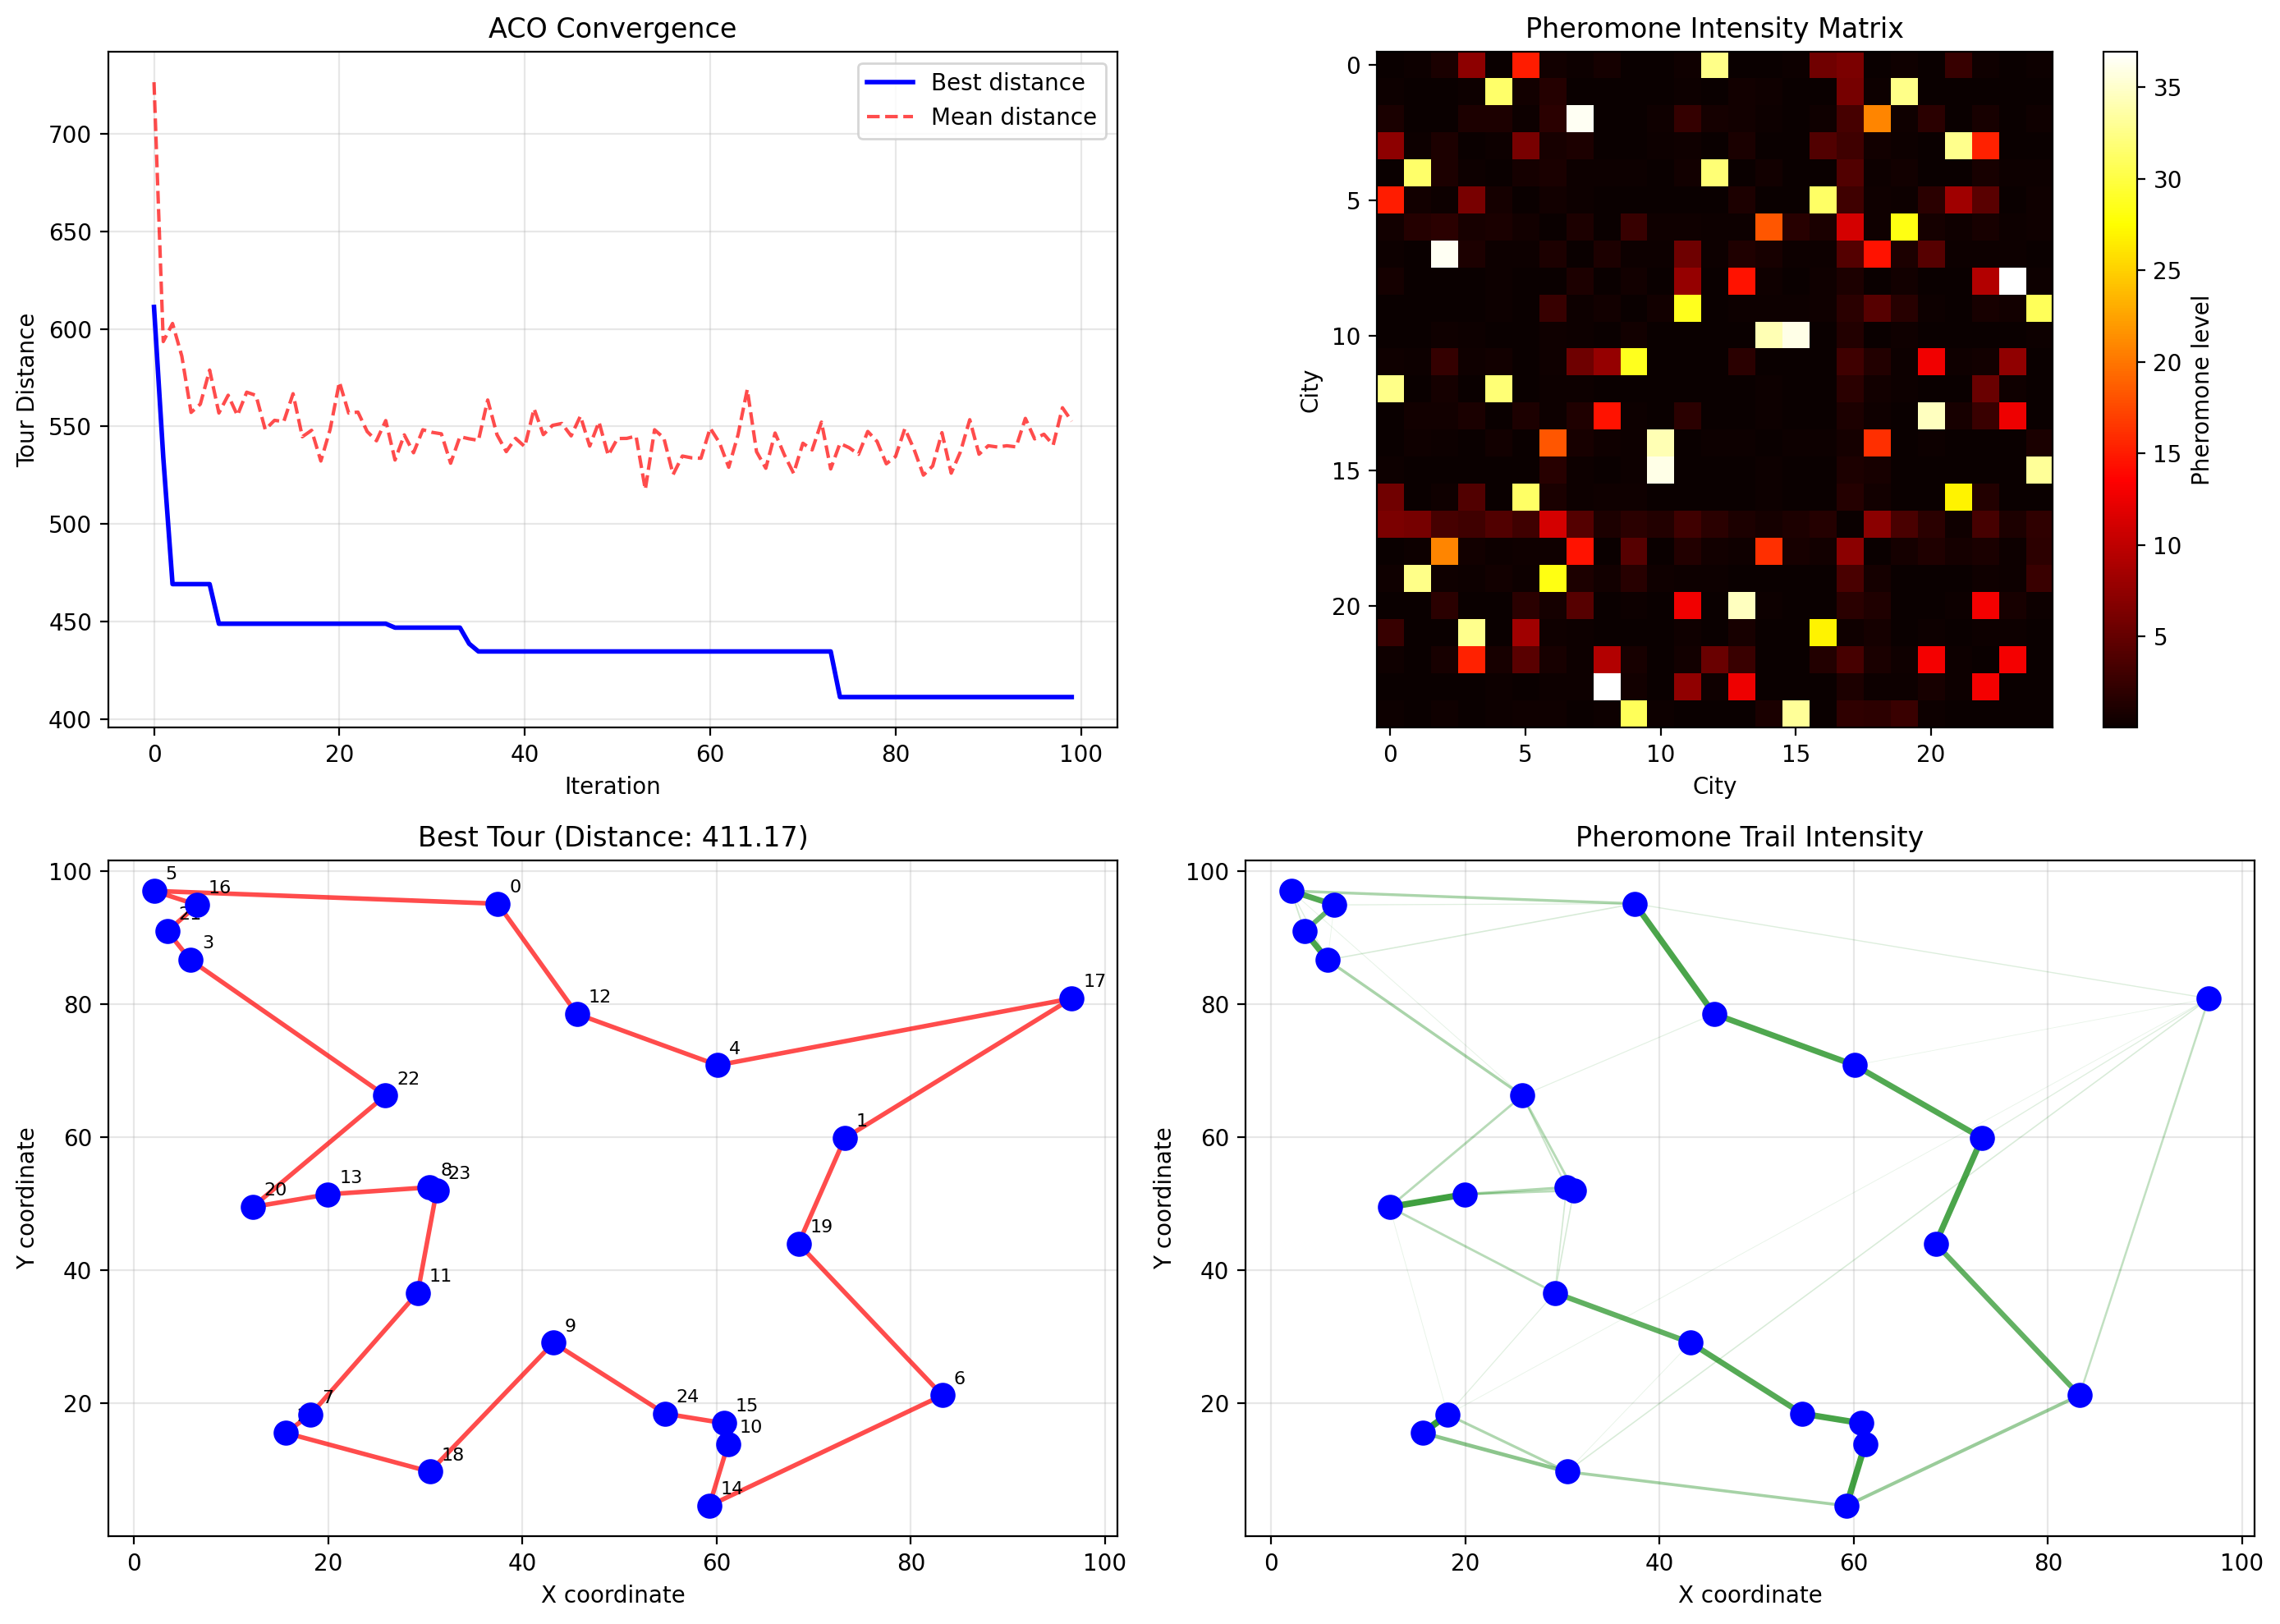


Plot saved to 'plot.png'


In [5]:
# Create comprehensive visualization
fig = plt.figure(figsize=(14, 10))

# Plot 1: Convergence history
ax1 = fig.add_subplot(2, 2, 1)
iterations = [h['iteration'] for h in aco.history]
best_distances = [h['best_distance'] for h in aco.history]
mean_distances = [h['mean_distance'] for h in aco.history]

ax1.plot(iterations, best_distances, 'b-', linewidth=2, label='Best distance')
ax1.plot(iterations, mean_distances, 'r--', alpha=0.7, label='Mean distance')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Tour Distance')
ax1.set_title('ACO Convergence')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Pheromone intensity heatmap
ax2 = fig.add_subplot(2, 2, 2)
im = ax2.imshow(aco.pheromones, cmap='hot', interpolation='nearest')
ax2.set_xlabel('City')
ax2.set_ylabel('City')
ax2.set_title('Pheromone Intensity Matrix')
plt.colorbar(im, ax=ax2, label='Pheromone level')

# Plot 3: Best tour visualization
ax3 = fig.add_subplot(2, 2, 3)

# Plot cities
ax3.scatter(cities[:, 0], cities[:, 1], c='blue', s=100, zorder=5)
for i, (x, y) in enumerate(cities):
    ax3.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

# Plot tour
tour_cities = [cities[i] for i in best_tour]
tour_cities.append(tour_cities[0])  # Close the loop
tour_cities = np.array(tour_cities)

ax3.plot(tour_cities[:, 0], tour_cities[:, 1], 'r-', linewidth=2, alpha=0.7)
ax3.set_xlabel('X coordinate')
ax3.set_ylabel('Y coordinate')
ax3.set_title(f'Best Tour (Distance: {best_distance:.2f})')
ax3.grid(True, alpha=0.3)

# Plot 4: Pheromone trails on graph
ax4 = fig.add_subplot(2, 2, 4)

# Normalize pheromones for visualization
pheromone_max = aco.pheromones.max()
pheromone_min = aco.pheromones.min()

# Draw edges with thickness proportional to pheromone level
for i in range(n_cities):
    for j in range(i + 1, n_cities):
        pheromone_level = aco.pheromones[i, j]
        normalized = (pheromone_level - pheromone_min) / (pheromone_max - pheromone_min + 1e-10)
        if normalized > 0.1:  # Only draw significant trails
            ax4.plot([cities[i, 0], cities[j, 0]], 
                    [cities[i, 1], cities[j, 1]], 
                    'g-', alpha=normalized * 0.8, linewidth=normalized * 3)

ax4.scatter(cities[:, 0], cities[:, 1], c='blue', s=100, zorder=5)
ax4.set_xlabel('X coordinate')
ax4.set_ylabel('Y coordinate')
ax4.set_title('Pheromone Trail Intensity')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ant_colony_optimization_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Analysis and Results

The visualization above shows:

1. **Convergence Plot**: The algorithm rapidly improves in early iterations and then converges to a stable solution. The gap between mean and best distances indicates the exploration-exploitation balance.

2. **Pheromone Matrix**: Brighter cells indicate stronger pheromone trails between cities. The diagonal is zero (no self-loops).

3. **Best Tour**: The optimal route found by the algorithm, connecting all cities with minimal total distance.

4. **Pheromone Trails**: Visual representation of the learned solution structure. Stronger trails (thicker, more opaque lines) indicate preferred connections.

## Key Observations

- **Parameter Sensitivity**: The balance between $\alpha$ (pheromone influence) and $\beta$ (heuristic influence) is crucial. Higher $\beta$ values lead to more greedy behavior, while higher $\alpha$ values emphasize learned information.

- **Evaporation Rate**: The parameter $\rho$ controls how quickly old information is forgotten. Too high evaporation leads to loss of good solutions; too low leads to premature convergence.

- **Swarm Intelligence**: No single ant finds the optimal solution. Instead, the collective behavior of the colony, mediated through pheromone communication, gradually uncovers good solutions.

## Conclusion

Ant Colony Optimization demonstrates how simple local rules can lead to complex global optimization behavior. The algorithm's strength lies in its:

- **Positive feedback**: Good solutions are reinforced through pheromone deposits
- **Negative feedback**: Evaporation allows the system to forget poor solutions
- **Stochastic exploration**: Random elements prevent premature convergence
- **Distributed computation**: Multiple ants work independently, making the algorithm naturally parallelizable

ACO has been successfully applied to various combinatorial optimization problems including vehicle routing, scheduling, network optimization, and protein folding.